In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
# Import the CIFAR-10 dataset and rescale the pixel values
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

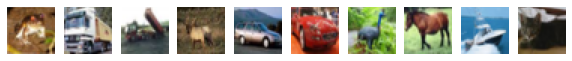

In [4]:
# Plot the first 10 CIFAR-10 images
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

In [5]:
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [6]:
def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:
model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 7, 7, 8)           0         
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                12576     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 14,514
Trainable params: 14,514
Non-traina

In [8]:
get_test_accuracy(model, x_test, y_test)

accuracy: 0.081


In [10]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             frequency='epoch',
                             save_weights_only=True,
                             verbose=1)

In [11]:
model.fit(x=x_train, y=y_train, epochs=3,
          callbacks=[checkpoint])

Epoch 1/3
313/313 [==============================] - ETA: 0s - loss: 1.9380 - accuracy: 0.2859
Epoch 1: saving model to model_checkpoints\checkpoint
313/313 [==============================] - 6s 5ms/step - loss: 1.9380 - accuracy: 0.2859
Epoch 2/3
312/313 [============================>.] - ETA: 0s - loss: 1.6047 - accuracy: 0.4161
Epoch 2: saving model to model_checkpoints\checkpoint
313/313 [==============================] - 1s 5ms/step - loss: 1.6046 - accuracy: 0.4161
Epoch 3/3
308/313 [============================>.] - ETA: 0s - loss: 1.4722 - accuracy: 0.4689
Epoch 3: saving model to model_checkpoints\checkpoint
313/313 [==============================] - 1s 5ms/step - loss: 1.4720 - accuracy: 0.4686


In [12]:
get_test_accuracy(model, x_test, y_test)

accuracy: 0.484


In [13]:
new_model = get_new_model()
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.107


In [14]:
new_model.load_weights(checkpoint_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.484


In [15]:
checkpoint_1000_path = 'model_checkpoints_1000/checkpoint_{epoch:02d}_{batch:04d}'
checkpoint_1000 = ModelCheckpoint(filepath=checkpoint_1000_path,
                                  save_weights_only=True,
                                  save_freq=1000,
                                  verbose=1)

In [16]:
model = get_new_model()
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test),
          epochs=3, batch_size=16,
          callbacks=[checkpoint_1000])

Epoch 1/3
625/625 [==============================] - 3s 5ms/step - loss: 1.8750 - accuracy: 0.3169 - val_loss: 1.5977 - val_accuracy: 0.4390
Epoch 2/3
366/625 [================>.............] - ETA: 0s - loss: 1.5256 - accuracy: 0.4549
Epoch 2: saving model to model_checkpoints_1000\checkpoint_02_0375
625/625 [==============================] - 3s 4ms/step - loss: 1.5044 - accuracy: 0.4582 - val_loss: 1.4605 - val_accuracy: 0.4750
Epoch 3/3
625/625 [==============================] - 2s 4ms/step - loss: 1.3997 - accuracy: 0.4934 - val_loss: 1.4124 - val_accuracy: 0.5030


In [17]:
checkpoint_test_path = 'checkpoints_every_epoch/checkpoint_{epoch:03d}'
checkpoint_test = ModelCheckpoint(filepath=checkpoint_test_path,
                              frequency='epoch',
                              save_weights_only=True,
                              verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [18]:
test_model = get_new_model()
test_model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test),
          epochs=30, batch_size=16,
          callbacks=[checkpoint_test, early_stopping])

Epoch 1/30
621/625 [============================>.] - ETA: 0s - loss: 1.8991 - accuracy: 0.3081
Epoch 1: saving model to checkpoints_every_epoch\checkpoint_001
625/625 [==============================] - 3s 4ms/step - loss: 1.8982 - accuracy: 0.3088 - val_loss: 1.6265 - val_accuracy: 0.4240
Epoch 2/30
624/625 [============================>.] - ETA: 0s - loss: 1.5376 - accuracy: 0.4456
Epoch 2: saving model to checkpoints_every_epoch\checkpoint_002
625/625 [==============================] - 3s 5ms/step - loss: 1.5371 - accuracy: 0.4456 - val_loss: 1.5080 - val_accuracy: 0.4560
Epoch 3/30
619/625 [============================>.] - ETA: 0s - loss: 1.3988 - accuracy: 0.5062
Epoch 3: saving model to checkpoints_every_epoch\checkpoint_003
625/625 [==============================] - 4s 6ms/step - loss: 1.3978 - accuracy: 0.5061 - val_loss: 1.3799 - val_accuracy: 0.5050
Epoch 4/30
614/625 [============================>.] - ETA: 0s - loss: 1.3151 - accuracy: 0.5345
Epoch 4: saving model to checkp

In [19]:
get_test_accuracy(test_model, x_test, y_test)

accuracy: 0.576


In [20]:
load_test_model = get_new_model()
get_test_accuracy(load_test_model, x_test, y_test)

accuracy: 0.125


In [21]:
checkpoint_path = 'checkpoints_every_epoch/checkpoint_021'
load_test_model.load_weights(checkpoint_path)

In [22]:
get_test_accuracy(load_test_model, x_test, y_test)

accuracy: 0.576


In [23]:
small_x_train = x_train[:100]
small_y_train = y_train[:100]
small_x_test = x_test[:100]
small_y_test = y_test[:100]

In [24]:
model = get_new_model()

In [25]:
checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1)

In [26]:
history = model.fit(x=small_x_train, y=small_y_train, validation_data=(small_x_test, small_y_test),
                    epochs=50, batch_size=16,
                    callbacks=[checkpoint_best],
                    verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.09000, saving model to model_checkpoints_best\checkpoint

Epoch 2: val_accuracy did not improve from 0.09000

Epoch 3: val_accuracy did not improve from 0.09000

Epoch 4: val_accuracy did not improve from 0.09000

Epoch 5: val_accuracy did not improve from 0.09000

Epoch 6: val_accuracy did not improve from 0.09000

Epoch 7: val_accuracy did not improve from 0.09000

Epoch 8: val_accuracy improved from 0.09000 to 0.13000, saving model to model_checkpoints_best\checkpoint

Epoch 9: val_accuracy did not improve from 0.13000

Epoch 10: val_accuracy did not improve from 0.13000

Epoch 11: val_accuracy did not improve from 0.13000

Epoch 12: val_accuracy did not improve from 0.13000

Epoch 13: val_accuracy improved from 0.13000 to 0.14000, saving model to model_checkpoints_best\checkpoint

Epoch 14: val_accuracy improved from 0.14000 to 0.19000, saving model to model_checkpoints_best\checkpoint

Epoch 15: val_accuracy did not improve from 0.190

In [27]:
get_test_accuracy(model, small_x_test, small_y_test)

accuracy: 0.220


<AxesSubplot:>

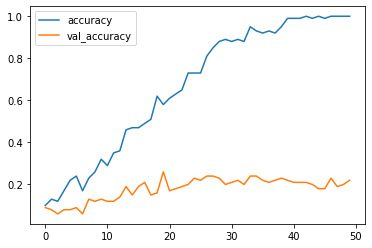

In [28]:
df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [29]:
new_model = get_new_model()
get_test_accuracy(new_model, small_x_test, small_y_test)

accuracy: 0.070


In [30]:
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, small_x_test, small_y_test)

accuracy: 0.260


In [31]:
new_model.save('models/my_model.h5')

In [32]:
loaded_model = load_model('my_model.h5')
get_test_accuracy(loaded_model, x_test, y_test)

accuracy: 0.210


In [33]:
loaded_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 7, 7, 8)           0         
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                12576     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 14,514
Trainable params: 14,514
Non-trai

In [34]:
config_dict = loaded_model.get_config()
print(config_dict)

{'name': 'sequential_6', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 32, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv_1_input'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv_1', 'trainable': True, 'batch_input_shape': (None, 32, 32, 3), 'dtype': 'float32', 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Conv2D', 'config': {'name': 'conv_2', 'trainable': True, 'dtype': 'float32', 'filters': 8, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dila

In [35]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [36]:
resnet50 = ResNet50(weights='imagenet')
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [37]:
lemon_img = load_img('lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('water_tower.jpg', target_size=(224, 224))

In [38]:
def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(resnet50.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

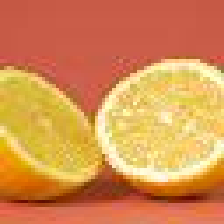

In [39]:
lemon_img

In [40]:
get_top_5_predictions(lemon_img)

,prediction,probability
1,consomme,0.237066
2,eggnog,0.226406
3,lemon,0.199257
4,face_powder,0.030634
5,ladle,0.030447


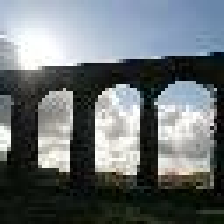

In [41]:
viaduct_img

In [44]:
get_top_5_predictions(viaduct_img)

,prediction,probability
1,vault,0.433361
2,viaduct,0.113641
3,prison,0.107958
4,window_screen,0.067979
5,megalith,0.016871


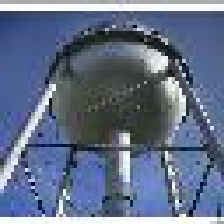

In [45]:
water_tower_img

In [46]:
get_top_5_predictions(water_tower_img)

,prediction,probability
1,solar_dish,0.483133
2,ladle,0.165878
3,planetarium,0.101512
4,strainer,0.052545
5,jigsaw_puzzle,0.023844


In [47]:
import tensorflow_hub as hub

In [48]:
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/5"
hub_model = Sequential([hub.KerasLayer(module_url)])
hub_model.build(input_shape=[None, 160, 160, 3])
hub_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              1343049   
                                                                 
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


In [55]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

html = urlopen("https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt")  

bsObject = BeautifulSoup(html, "html.parser") 


print(bsObject) # 웹 문서 전체가 출력됩니다.

background
tench
goldfish
great white shark
tiger shark
hammerhead
electric ray
stingray
cock
hen
ostrich
brambling
goldfinch
house finch
junco
indigo bunting
robin
bulbul
jay
magpie
chickadee
water ouzel
kite
bald eagle
vulture
great grey owl
European fire salamander
common newt
eft
spotted salamander
axolotl
bullfrog
tree frog
tailed frog
loggerhead
leatherback turtle
mud turtle
terrapin
box turtle
banded gecko
common iguana
American chameleon
whiptail
agama
frilled lizard
alligator lizard
Gila monster
green lizard
African chameleon
Komodo dragon
African crocodile
American alligator
triceratops
thunder snake
ringneck snake
hognose snake
green snake
king snake
garter snake
water snake
vine snake
night snake
boa constrictor
rock python
Indian cobra
green mamba
sea snake
horned viper
diamondback
sidewinder
trilobite
harvestman
scorpion
black and gold garden spider
barn spider
garden spider
black widow
tarantula
wolf spider
tick
centipede
black grouse
ptarmigan
ruffed grouse
prairie chic

In [63]:
f = open("ImageNetLabels.txt", 'w')
for content in bsObject:
    f.write(content)
f.close()

In [64]:
with open('ImageNetLabels.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [65]:
print(len(categories))
print(categories[1000])

1001

In [75]:
def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = hub_model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

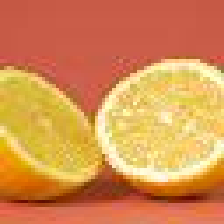

In [76]:
lemon_img

In [77]:
get_top_5_predictions(lemon_img)

,prediction
1,tray
2,shower cap
3,candle
4,toilet seat
5,mosquito net


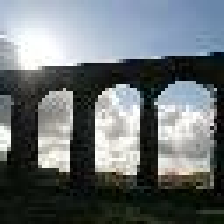

In [78]:
viaduct_img

In [79]:
get_top_5_predictions(viaduct_img)

,prediction
1,bell cote
2,viaduct
3,pedestal
4,monastery
5,triumphal arch


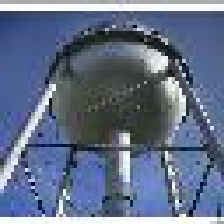

In [80]:
water_tower_img

In [81]:
get_top_5_predictions(water_tower_img)

,prediction
1,solar dish
2,prison
3,planetarium
4,fountain
5,jigsaw puzzle
